In [63]:
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
%matplotlib inline
le = LabelEncoder()

In [64]:
sample = pd.read_csv('SF_crime/sampleSubmission.csv')
test = pd.read_csv('SF_crime/test.csv', index_col='Id')
test = test.rename(columns={'X': 'Longitude', "Y": "Latitude"})
test.Dates = pd.to_datetime(test.Dates)
test_keep = test
crime_in_sf = pd.read_csv('SF_crime/train.csv')
crime_in_sf.Dates = pd.to_datetime(crime_in_sf.Dates)
crime_in_sf = crime_in_sf.rename(columns={'X': 'Longitude', "Y": "Latitude",})
crime_in_sf = crime_in_sf.drop(['Resolution', 'Descript'], axis=1)
crime_train, crime_test = train_test_split(crime_in_sf, test_size=.4)

In [65]:
for column in test.columns.values:
    if column != 'Dates' and column != 'Longitude' and column != 'Latitude':
        le.fit(test[column])
        test[column] = le.transform(test[column])

for column in crime_in_sf.columns.values:
    if column != 'Dates' and column != 'Longitude' and column != 'Latitude':
        le.fit(crime_in_sf[column])
        crime_train[column] = le.transform(crime_train[column])

for column in crime_in_sf.columns.values:
    if column != 'Dates' and column != 'Longitude' and column != 'Latitude':
        le.fit(crime_in_sf[column])        
        crime_test[column] = le.transform(crime_test[column])

/Users/MatthewBarnette/final_project_2/.direnv/python-3.5.0/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/MatthewBarnette/final_project_2/.direnv/python-3.5.0/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [66]:
crime_train.head()

,Dates,Category,DayOfWeek,PdDistrict,Address,Longitude,Latitude
744670,2004-10-14 22:27:00,21,4,3,22344,-122.412690,37.749369
580447,2007-02-23 23:44:00,37,0,8,1989,-122.461240,37.709723
425065,2009-05-16 11:30:00,16,2,7,18822,-122.408068,37.783992
441229,2009-03-02 10:30:00,36,1,8,10590,-122.505117,37.764213
253320,2011-12-15 00:30:00,36,4,2,436,-122.423681,37.743129


In [67]:
categories = crime_train.Category
crime_train = crime_train.drop('Category', axis=1)

categories2 = crime_test.Category
crime_test = crime_test.drop('Category', axis=1)

In [68]:
dtrain = xgb.DMatrix(crime_train.as_matrix(),
                     label=categories)
dtest = xgb.DMatrix(crime_test.as_matrix(),
                    label=categories2)

ValueError: could not convert string to float: '2003-06-28 12:00:00'

In [42]:
param = {'bst:max_depth':2, 'bst:eta':1, 'silent':1, 'objective':'multi:softprob', 'num_class':39}
param['nthread'] = 4
param['eval_metric'] = ['logloss', 'map']

In [43]:
evallist  = [(dtest,'eval'), (dtrain,'train')]

In [44]:
num_round = 15
bst = xgb.train(param, 
                dtrain, 
                num_round)

In [45]:
predictions = bst.predict(xgb.DMatrix(test.as_matrix()), output_margin=False)

In [46]:
predictions = pd.DataFrame(predictions)

In [47]:
le.fit(crime_in_sf.Category)
predictions.columns = le.inverse_transform(predictions.columns)

In [48]:
predictions['Id'] = predictions.index

In [49]:
def order(frame,var):
    varlist =[w for w in frame.columns if w not in var]
    frame = frame[var+varlist]
    return frame
predictions = order(predictions,['Id'])

In [50]:
predictions.to_csv('predictions_XGB.csv', index=False)

In [51]:
pred_test = predictions.head()

In [52]:
predictions

,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0.002962,0.148530,0.000259,1.356516e-07,0.040862,0.001581,0.000937,0.024426,0.003398,...,0.000158,0.001900,0.000428,0.044333,5.905414e-06,0.007835,0.062458,0.086585,4.600548e-02,1.495122e-02
1,1,0.003759,0.150458,0.000169,1.374132e-07,0.041392,0.001601,0.000949,0.024743,0.003975,...,0.000378,0.001925,0.000434,0.044909,5.982100e-06,0.007937,0.063269,0.087709,4.660289e-02,1.514537e-02
2,2,0.002145,0.095383,0.000340,3.738062e-04,0.144326,0.002514,0.001137,0.012851,0.005108,...,0.000063,0.008695,0.000638,0.036887,8.524238e-06,0.010380,0.081633,0.024682,4.748707e-02,6.917807e-03
3,3,0.003203,0.137617,0.001063,4.615380e-07,0.057741,0.001430,0.001631,0.015078,0.004147,...,0.000441,0.001851,0.000843,0.040090,6.241564e-06,0.004904,0.078190,0.063103,2.054799e-02,1.252515e-02
4,4,0.003203,0.137617,0.001063,4.615380e-07,0.057741,0.001430,0.001631,0.015078,0.004147,...,0.000441,0.001851,0.000843,0.040090,6.241564e-06,0.004904,0.078190,0.063103,2.054799e-02,1.252515e-02
5,5,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
6,6,0.002709,0.077981,0.000395,3.317989e-04,0.065739,0.001628,0.001128,0.026605,0.004089,...,0.000085,0.005141,0.001107,0.045644,7.106106e-06,0.005583,0.067540,0.071844,2.339417e-02,9.153667e-03
7,7,0.003157,0.090861,0.000460,3.866042e-04,0.057291,0.002301,0.001314,0.030999,0.004764,...,0.000099,0.005711,0.001118,0.053183,8.279866e-06,0.006505,0.078696,0.083710,4.014102e-02,1.591325e-02
8,8,0.002743,0.079927,0.000295,6.011321e-04,0.037648,0.006787,0.001829,0.051322,0.006664,...,0.000169,0.008712,0.000757,0.039384,1.370816e-05,0.009034,0.073837,0.039692,4.426140e-02,1.403552e-02
9,9,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00


In [53]:
pred_test

,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0.002962,0.148530,0.000259,1.356516e-07,0.040862,0.001581,0.000937,0.024426,0.003398,...,0.000158,0.001900,0.000428,0.044333,0.000006,0.007835,0.062458,0.086585,0.046005,0.014951
1,1,0.003759,0.150458,0.000169,1.374132e-07,0.041392,0.001601,0.000949,0.024743,0.003975,...,0.000378,0.001925,0.000434,0.044909,0.000006,0.007937,0.063269,0.087709,0.046603,0.015145
2,2,0.002145,0.095383,0.000340,3.738062e-04,0.144326,0.002514,0.001137,0.012851,0.005108,...,0.000063,0.008695,0.000638,0.036887,0.000009,0.010380,0.081633,0.024682,0.047487,0.006918
3,3,0.003203,0.137617,0.001063,4.615380e-07,0.057741,0.001430,0.001631,0.015078,0.004147,...,0.000441,0.001851,0.000843,0.040090,0.000006,0.004904,0.078190,0.063103,0.020548,0.012525
4,4,0.003203,0.137617,0.001063,4.615380e-07,0.057741,0.001430,0.001631,0.015078,0.004147,...,0.000441,0.001851,0.000843,0.040090,0.000006,0.004904,0.078190,0.063103,0.020548,0.012525


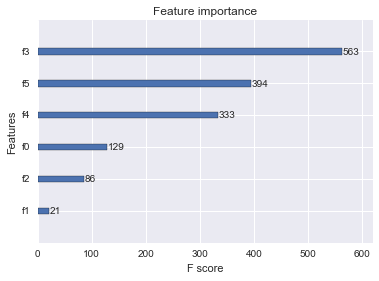

In [54]:
xgb.plot_importance(bst)